# Import

In [1]:
# calcium traces exploration - simple commands in pandas
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import scipy.stats
import os
import pickle
from matplotlib import cm
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# LAURA'S UPDATE: 07/06/2022
# data preprocessing finished, both animals timestamps and trial_info should be correct now. 
# animal 232 trial info in laura folder - to be fixed
# running the analyses again now

# Load airpuff calcium traces

In [81]:
"""
This script includes:
    -Decoding analysis on reward/punishment after & before response (for each session & across sessions)
    -Decoding analysis on stimulus left/right at stimulus onset (for each session & across sessions)
    -Decoding analysis on licking left/right before response (for each session & across sessions)

---------
Python 3.8.5

Dependencies:
    -numpy 1.19.2
    -pandas 1.1.3
    -scipy 1.6.3
    -matplotlib 3.3.2
    -seaborn 0.11.0
    -sklearn 0.0
    -csv, os, pickle
"""

'\nThis script includes:\n    -Decoding analysis on reward/punishment after & before response (for each session & across sessions)\n    -Decoding analysis on stimulus left/right at stimulus onset (for each session & across sessions)\n    -Decoding analysis on licking left/right before response (for each session & across sessions)\n\n---------\nPython 3.8.5\n\nDependencies:\n    -numpy 1.19.2\n    -pandas 1.1.3\n    -scipy 1.6.3\n    -matplotlib 3.3.2\n    -seaborn 0.11.0\n    -sklearn 0.0\n    -csv, os, pickle\n'

In [408]:
#### change chosen animal!!
chosen_animal = 233

if chosen_animal == 232:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_232/"
    non_airpuff_sessions = ['04','06','07','08','10','11','12','13'] # animal 232
    airpuff_sessions = ['14','16','17','18','19'] # animal 232
    all_sessions = ['04','06','07','08','10','11','12','13','14','16','17','18','19'] # animal 232
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "laura"
    
    
elif chosen_animal ==233:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_233/"
    non_airpuff_sessions = ['06','07','08','09','10','11','12','13'] # animal 233
    airpuff_sessions = ['14','15','16','17','18','19'] # animal 233
    all_sessions = ['06','07','08','09','10','11','12','13','14','15','16','17','18','19'] # animal 233
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "trial_info"

else:
    raise AssertionError('choose an available animal!')


In [414]:
#### change session
session = "06"

In [415]:
# load csv calcium traces
folder_name = "Calcium_Traces"
filename = "2021-05-{0}.csv".format(session)
df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
n_rows, n_columns = df.shape
# display the top of the table
#df.head()

# EXTRACT THE DATA YOU WILL NEED FOR THE ANALYSIS
# as you can see from the head, first row is useless, the first column is time, all the other columns are channels
# create time array
df_times = df[' '][1:-1]
df_num_time = pd.to_numeric(df_times, downcast='float')
time_array = df_num_time.to_numpy()
tot_timepoints = len(time_array)

# check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
time_sampling = np.zeros(shape=(len(time_array)-1,))
for i in range(1,len(time_array)):
    time_sampling[i-1] = time_array[i]-time_array[i-1]
#plt.plot(np.arange(len(time_array)-1), time_sampling, '.')
#plt.show()

#12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
# calcium data are sampled at 100 msec. 
sampling_rate = 0.1
tot_secs = int(tot_timepoints * sampling_rate)

#create channels array
n_channels = n_columns-1
channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
# fill empty channels array
for i in range(n_channels):
    col_name = df.columns[i+1]
    df_channel = df[col_name][1:-1]
    df_num_channel = pd.to_numeric(df_channel, downcast='float')
    channels_array[:,i] = df_num_channel.to_numpy()

# Check traces data

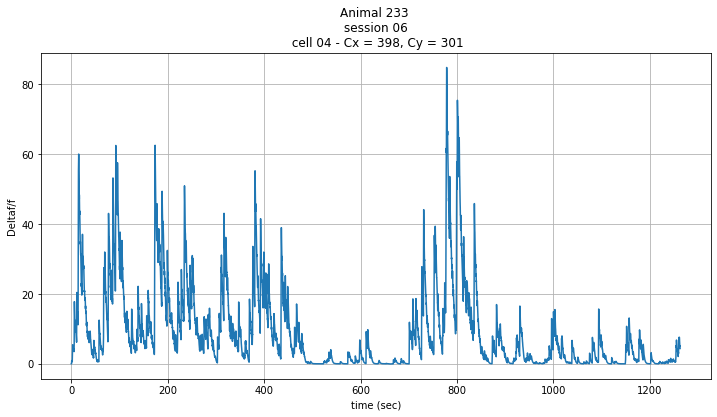

In [422]:
# check your data - plot some channels
units = [4]
fig, axs = plt.subplots(len(units),1, figsize=(12,6))

axs.plot(time_array,channels_array[:,units[u]])
axs.set_xlabel('time (sec)')
axs.set_ylabel('Deltaf/f')
#axs[u].set_ylim([-0.001,0.01])
#axs[u].set_ylim([-1,60])
axs.grid()
#axs[u].legend()
str_title = 'Animal 233 \n session 06 \n cell 04 - Cx = 398, Cy = 301'
plt.title(str_title)
#fig.suptitle('Calcium Imaging Granule Cells', y=0.9, fontsize=14, fontweight='bold')
plt.show()

# Load behavioural data

In [361]:

# LOAD BEHAVIOURAL DATA
if chosen_animal == 233:
    bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    trials_response = trial_info['trial_info'][0,0][2].ravel()
    trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    n_trials = len(trials_end_time) # number of trials

elif chosen_animal== 232:
    # CORRUPTED FILES - LOAD LAURA'S NEW VERSION

    bhv_info_filename = "trial_info_232laura_202105{0}.mat".format(session)
    trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

    # extract information from trial_info: in MATLAB this is a struct with the fields:
    trials_start_time = trial_info['trial_start_new'][0].ravel()
    trials_stimulus_on = trial_info['trial_stimulus_on'][0].ravel()
    trials_response = trial_info['trial_response'][0].ravel()
    trials_is_right_lick = trial_info['trial_is_right_lick'][0].ravel()
    trials_is_reward = trial_info['trial_is_reward'][0].ravel()
    trials_end_time = trial_info['trial_end_new'][0].ravel()
    n_trials = len(trials_end_time)
    

# restructure trials such that the waiting time before stimulus onset goes to the end of the previous trial

new_start = trials_stimulus_on - 0.5
new_end = np.zeros(shape=(n_trials,))

new_end[0:-1] = trials_stimulus_on[1:]-0.5
new_end[-1] = trials_end_time[-1]

    
# where was the stimulus? we don't have this info. But it can be reconstructed 
stimulus_reconstruction = np.zeros(shape=(n_trials,))
right_choice = np.where(trials_is_reward==1)[0]
stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
wrong_choice = np.where(trials_is_reward==0)[0]
stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

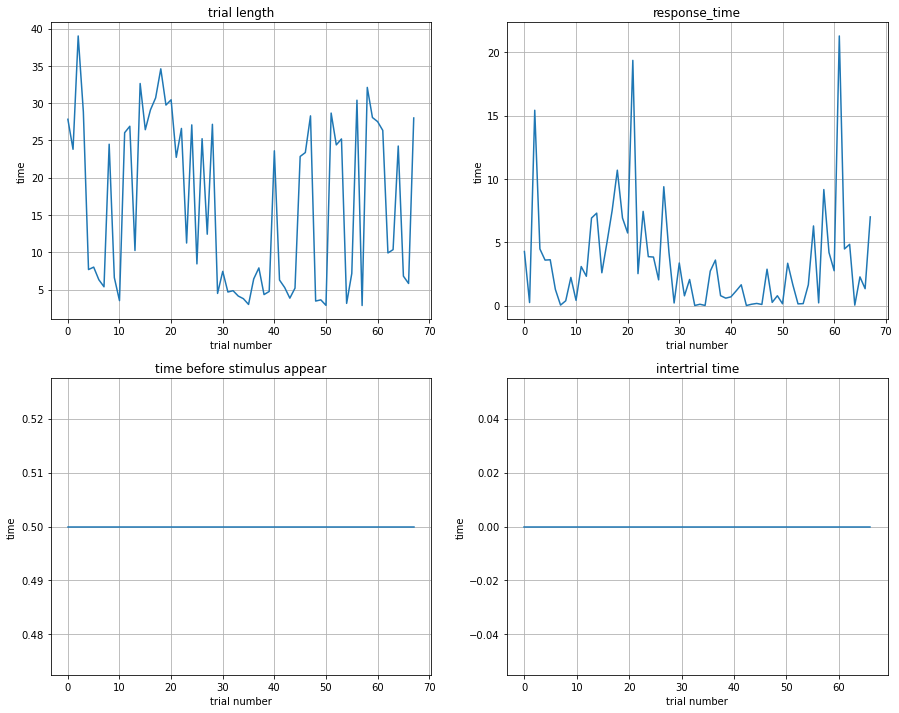

In [362]:
# trial length, response time, time before stimulus appears and intertrial time
fig, axs = plt.subplots(2,2,figsize=(15,12))
trials_length = new_end - new_start
response_time = trials_response - trials_stimulus_on
stim_time = trials_stimulus_on - new_start
intertrial_time = []
for i in range(1,n_trials):
    intertrial_time.append(new_start[i] - new_end[i-1])

# plot variables in subplots
axs[0, 0].plot(np.arange(n_trials), trials_length)
axs[0, 0].set_title('trial length')
axs[0, 1].plot(np.arange(n_trials), response_time)
axs[0, 1].set_title('response_time')
axs[1, 0].plot(np.arange(n_trials), stim_time)
axs[1, 0].set_title('time before stimulus appear')
axs[1, 1].plot(np.arange(n_trials-1), intertrial_time)
axs[1, 1].set_title('intertrial time')

# label axes
for ax in axs.flat:
    ax.set(xlabel='trial number', ylabel='time')
    ax.grid()
    
plt.show()

In [363]:
print("number of trials:",n_trials)
print("number of neurons:",n_channels)
print("ratio trials/neurons:", n_trials/n_channels)
print("performance:",np.sum(trials_is_reward),"/",n_trials,"=",(np.sum(trials_is_reward))/n_trials*100, "%")
print("average trial length (sec):",np.mean(trials_length) * sampling_rate) # in sec

number of trials: 68
number of neurons: 27
ratio trials/neurons: 2.5185185185185186
performance: 37 / 68 = 54.41176470588235 %
average trial length (sec): 1.6537083823529408


In [364]:
# split traces data into trials
X = {}
for i in range(n_trials):
    lower_bound = np.min(np.where(time_array>=new_start[i]))
    upper_bound = np.max(np.where(time_array<=new_end[i]))
    X[i] = channels_array[lower_bound:upper_bound,:]

# Normalisation

In [365]:
# normalize calcium data, bringing the firing of single units on the same scale. 
z_units = scipy.stats.zscore(channels_array)

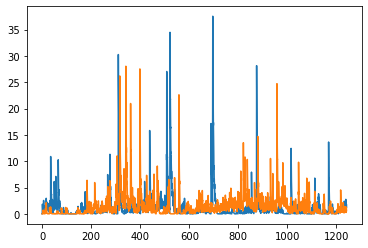

In [366]:
# check your data - plot some neurons
units = [15,22]
for u in range(len(units)):
    plt.plot(time_array,channels_array[:,units[u]], label='unit %d'%units[u])
plt.show()

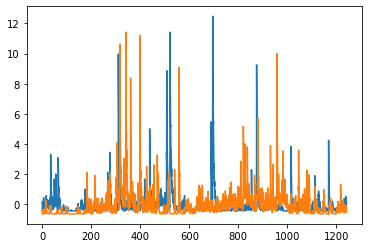

In [367]:
# compare with the normalized units
units = [15,22]
for u in range(len(units)):
    plt.plot(time_array,z_units[:,units[u]], label='unit %d'%units[u])
plt.show()

In [368]:
# split normalized traces data into trials
X_norm = {}
for i in range(n_trials):
    lower_bound = np.min(np.where(time_array>=new_start[i]))
    upper_bound = np.max(np.where(time_array<=new_end[i]))
    X_norm[i] = z_units[lower_bound:upper_bound,:]

# Analysis on reward and punishment (aligned at response)

In [369]:
# create the data array you will need to use as X with shape [n_trials, n_channels, n_timepoints]
# depending on what you want to test you will need to create different X

# trials have different length. Here Align them at the response, 
# and take the amount of points available in all trials around the response 

# set threshold for minimum time points before response
thr = 0.5
n_before_resp = 5 # number of timepoints before response - 500msec
n_after_resp = 15 # number of timepoints after response - 1500msec / 1.5sec
n_timepoints = n_before_resp+ n_after_resp # total number of timepoints in time window

selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1 # where enough timepoints
n_trials = np.sum(selected_trials) # number of trials

X_response = np.zeros(shape=(n_trials, n_timepoints , n_channels ))
j=0
for i in range(len(new_start)-1):
    if selected_trials[i]==1:
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
        x = X_norm[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
        X_response[j,:,:] = x
        j +=1

# transpose to have X in shape [n_trials, n_channels, n_timepoints]
X_response = X_response.transpose(0,2,1)

In [370]:
# analysis on reward and punishment, aligned at response
decode_str = 'reward_or_punish'
b = trials_is_reward[0:-1]
y = b[selected_trials==1]

# ANALYSIS ALL 
print("all units decoding - response aligned - %s" %decode_str)

overall_class_balance = np.mean(y)
print("%s class balance: "%decode_str)
print(overall_class_balance)

# use only last kernel
n_splits=3
all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


for t in range(n_timepoints):
    # if we want to decode from a group of units only
    # units_selection = np.arange(25,34)
    # xt = X_response[:,units_selection,t]
    
    # if we want to decode from all the units
    xt = X_response[:,:,t]
    #xt = X_response[:,0:5,t]
    

    #stratified kfold to ensure every split has balanced amount of class
    outer_skf = StratifiedKFold(n_splits=n_splits)
    s=0
    for train_index, test_index in outer_skf.split(xt,y):
        x_train, x_test = xt[train_index], xt[test_index]
        y_train, y_test = y[train_index], y[test_index]  

        #should be a grid search for tuning the parameter
        model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
        s +=1
                

all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5522388059701493


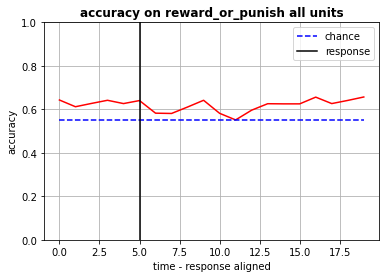

In [371]:
# plot reward or punishment at response
fig = plt.figure()
plt.plot(np.arange(n_timepoints), np.mean(all_units_accuracy_diag, axis=1),'r')
plt.plot(np.arange(n_timepoints), np.ones(shape=(n_timepoints,))*overall_class_balance, '--b', label="chance")
plt.axvline(x=n_before_resp, color='k', label="response")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

# Analysis stimulus (aligned at stimulus onset)

In [354]:
n_channels

41

In [372]:
# create other X, this time 
# align at stimulus onset and decode where the stimulus was
# select the amount of points available in all trials around the stimulus

stim_to_end_min = 20 #int(np.min(new_end - trials_stimulus_on) / sampling_rate) - 3400msec / 3.4sec
start_to_stim_min = 5 #int(np.min(trials_stimulus_on - new_start) / sampling_rate) - 500msec
n_timepoints = start_to_stim_min + stim_to_end_min

selected_trials = (new_end[0:-1] - trials_stimulus_on[0:-1]) *10 >= stim_to_end_min
n_trials = np.sum(selected_trials)

#n_trials = len(new_end)
X_stimulus = np.zeros(shape=(n_trials, n_timepoints , n_channels))

j=0
for i in range(len(new_start)-1):
    if selected_trials[i]==1:
        stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) / sampling_rate)
        X_stimulus[j,:,:] = X_norm[i][stim_timepoint-start_to_stim_min:stim_timepoint+stim_to_end_min,:]
        j +=1
    
#transpose to have them in the right shape
X_stimulus = X_stimulus.transpose(0,2,1)

In [373]:
# analysis stimulus left or right with data aligned at stimulus onset
decode_str = 'stimulus_left_or_right'
y = stimulus_reconstruction[np.where(selected_trials)]

# ANALYSIS ALL 
print("all units decoding - stimulus aligned - %s" %decode_str)

overall_class_balance = np.mean(y)
print("%s class balance: "%decode_str)
print(overall_class_balance)

# use only last kernel
n_splits=5
all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


for t in range(n_timepoints):
    # if we want only some units
    # ideally a meaningful subset of units - i.e. those highly correlated at stimulus onset
    # units_selection = [2,32]
    # xt = X_response[:,units_selection,t]
    
    # if we want to decode from all of the units
    xt = X_stimulus[:,:,t]

    #stratified kfold to ensure every split has balanced amount of class
    outer_skf = StratifiedKFold(n_splits=n_splits)
    s=0
    for train_index, test_index in outer_skf.split(xt,y):
        x_train, x_test = xt[train_index], xt[test_index]
        y_train, y_test = y[train_index], y[test_index]  

        #should be a grid search for tuning the parameter
        model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
        s +=1           

all units decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.5223880597014925


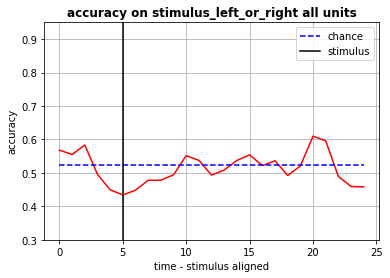

In [374]:
# plot stimulus decoding
fig = plt.figure()
plt.plot(np.arange(n_timepoints), np.mean(all_units_accuracy_diag, axis=1),'r')
plt.plot(np.arange(n_timepoints), np.ones(shape=(n_timepoints,))*overall_class_balance, '--b', label="chance")
plt.axvline(x=start_to_stim_min, color='k', label="stimulus")
plt.ylim([0.3,.95])
plt.grid()
plt.legend()
plt.xlabel('time - stimulus aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

# Analysis on reward and punishment (BEFORE response)

In [212]:
# create the data array you will need to use as X with shape [n_trials, n_channels, n_timepoints]
# depending on what you want to test you will need to create different X

# trials have different length. Here Align them at the response, 
# and take the amount of points available in all trials around the response 

# set threshold for minimum time points before response
thr = 0.6 #0.7
n_before_resp = 6 #7
n_after_resp = 2 #15
n_timepoints = n_before_resp+ n_after_resp

selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1
n_trials = np.sum(selected_trials)

X_response = np.zeros(shape=(n_trials, n_timepoints , n_channels ))
j=0
for i in range(len(new_start)-1):
    if selected_trials[i]==1:
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
        x = X_norm[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
        X_response[j,:,:] = x
        j +=1

# transpose to have X in shape [n_trials, n_channels, n_timepoints]
X_response = X_response.transpose(0,2,1)

In [213]:
# analysis on reward and punishment, before response
decode_str = 'reward_or_punish'
b = trials_is_reward[0:-1]
y = b[selected_trials==1]

# ANALYSIS ALL 
print("all units decoding - before response - %s" %decode_str)

overall_class_balance = np.mean(y)
print("%s class balance: "%decode_str)
print(overall_class_balance)

# use only last kernel
n_splits=3
all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


for t in range(n_timepoints):
    # if we want to decode from a group of units only
    # units_selection = np.arange(25,34)
    # xt = X_response[:,units_selection,t]
    
    # if we want to decode from all the units
    xt = X_response[:,:,t]
    #xt = X_response[:,0:5,t]
    

    #stratified kfold to ensure every split has balanced amount of class
    outer_skf = StratifiedKFold(n_splits=n_splits)
    s=0
    for train_index, test_index in outer_skf.split(xt,y):
        x_train, x_test = xt[train_index], xt[test_index]
        y_train, y_test = y[train_index], y[test_index]  

        #should be a grid search for tuning the parameter
        model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
        s +=1
                

all units decoding - before response - reward_or_punish
reward_or_punish class balance: 
0.752


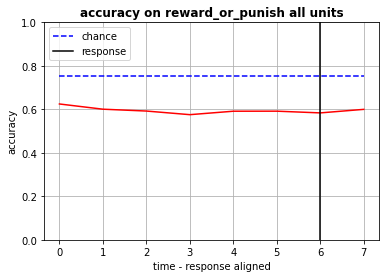

In [214]:
# plot reward or punishment before response
fig = plt.figure()
plt.plot(np.arange(n_timepoints), np.mean(all_units_accuracy_diag, axis=1),'r')
plt.plot(np.arange(n_timepoints), np.ones(shape=(n_timepoints,))*overall_class_balance, '--b', label="chance")
plt.axvline(x=n_before_resp, color='k', label="response")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

# Analysis on reward and punishment across all sessions (aligned at response)

all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.4727272727272727
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5217391304347826
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.6050420168067226
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.753731343283582
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.7814569536423841


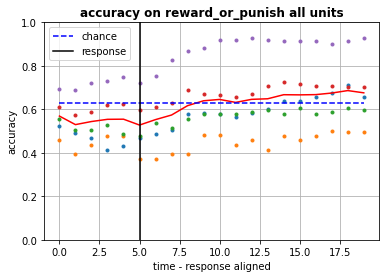

In [216]:
# set threshold for minimum time points before response
thr = 0.5
n_before_resp = 5
n_after_resp = 15
n_timepoints = n_before_resp+ n_after_resp

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

sessions_airpuff_232 = [14,16,17,18,19]


# for each airpuff session:
for session in sessions_airpuff_232:

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    folder_name = "laura"
    bhv_info_filename = "trial_info_232laura_202105{0}.mat".format(session)
    trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    trials_start_time = trial_info['trial_start_new'][0].ravel()
    trials_stimulus_on = trial_info['trial_stimulus_on'][0].ravel()
    trials_response = trial_info['trial_response'][0].ravel()
    trials_is_right_lick = trial_info['trial_is_right_lick'][0].ravel()
    trials_is_reward = trial_info['trial_is_reward'][0].ravel()
    trials_end_time = trial_info['trial_end_new'][0].ravel()
    n_trials = len(trials_end_time)
    
    # load behavioural data (.pkl file)
    #input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    #with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
    #     trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    #trials_start_time = np.array(trial_info['start_time'])
    #trials_stimulus_on = np.array(trial_info['stimulus_on'])
    #trials_response = np.array(trial_info['response'])
    #trials_is_right_lick = np.array(trial_info['is_right_lick'])
    #trials_is_reward = np.array(trial_info['is_reward'])
    #trials_end_time = np.array(trial_info['end_trial'])
    #n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    
    new_start = trials_stimulus_on - 0.5
    new_end = np.zeros(shape=(n_trials,))

    new_end[0:-1] = trials_stimulus_on[1:]-0.5
    new_end[-1] = trials_end_time[-1]

    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
        
    # normalize calcium data, bringing the firing of single units on the same scale. 
    z_units = scipy.stats.zscore(channels_array)
    # split traces data by trials
    X_norm = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X_norm[i] = z_units[lower_bound:upper_bound,:]
        
    #### DECODING ####
    selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1
    n_trials = np.sum(selected_trials)

    X_response = np.zeros(shape=(n_trials, n_timepoints , n_channels ))
    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            x = X_norm[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
            X_response[j,:,:] = x
            j +=1

    # transpose to have X in shape [n_trials, n_channels, n_timepoints]
    X_response = X_response.transpose(0,2,1)
    
    # analysis on reward and punishment, aligned at response
    decode_str = 'reward_or_punish'
    b = trials_is_reward[0:-1]
    y = b[selected_trials==1]

    # ANALYSIS ALL 
    print("all units decoding - response aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)

    # use only last kernel
    n_splits=3
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):
        # if we want to decode from a group of units only
        # units_selection = np.arange(25,34)
        # xt = X_response[:,units_selection,t]

        # if we want to decode from all the units
        xt = X_response[:,:,t]


        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1
    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))
            
# plot reward or punishment at response (across sessions)
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.') #,color='r')

plt.plot(x, y1,'r')
plt.plot(x, y2, '--b', label="chance")
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=n_before_resp, color='k', label="response")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

In [6]:
# saving as pickle file
output_filename = "assemblies_activity/response_airpuff_activity.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(y1, fp, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'y1' is not defined

# Analysis stimulus across all sessions (aligned at stimulus onset)

In [7]:
# set threshold for minimum time points before response
stim_to_end_min = 24 
start_to_stim_min = 5

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

# for each airpuff session:
for session in range(14,20):

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
        
    # normalize calcium data, bringing the firing of single units on the same scale. 
    z_units = scipy.stats.zscore(channels_array)
    X_norm = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X_norm[i] = z_units[lower_bound:upper_bound,:]
        
    #### DECODING ####
    selected_trials = (new_end[0:-1] - trials_stimulus_on[0:-1]) * 10 > 35
    n_trials = np.sum(selected_trials)

    n_timepoints = start_to_stim_min + stim_to_end_min
    X_stimulus = np.zeros(shape=(n_trials, n_timepoints , n_channels))

    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) / sampling_rate)
            X_stimulus[j,:,:] = X_norm[i][stim_timepoint-start_to_stim_min:stim_timepoint+stim_to_end_min,:]
            j +=1

    #transpose to have them in the right shape
    X_stimulus = X_stimulus.transpose(0,2,1)
    
    
    # analysis stimulus left or right with data aligned at stimulus onset
    decode_str = 'stimulus_left_or_right'
    y = stimulus_reconstruction[np.where(selected_trials)]

    # ANALYSIS ALL 
    print("all units decoding - stimulus aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)

    # use only last kernel
    n_splits=5
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):
        xt = X_stimulus[:,:,t]

        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1
    
    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))


    
# plot stimulus decoding
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.') #,color='r')

plt.plot(x, y1,'r')
plt.plot(x, y2, '--b', label="chance")
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=start_to_stim_min, color='k', label="stimulus")
plt.ylim([0.3,.95])
plt.grid()
plt.legend()
plt.xlabel('time - stimulus aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()
    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/felicia/Documents/CFIN/233/233_traces/trial_info/trial_info_2021-05-14.pkl'

In [8]:
# saving as pickle file
output_filename = "assemblies_activity/stimulus_airpuff_activity.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(y1, fp, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'y1' is not defined

# Analysis on reward and punishment across all sessions (BEFORE response)

all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.4745762711864407
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5285714285714286
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.6194690265486725
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.6610169491525424
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.8
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.8846153846153846


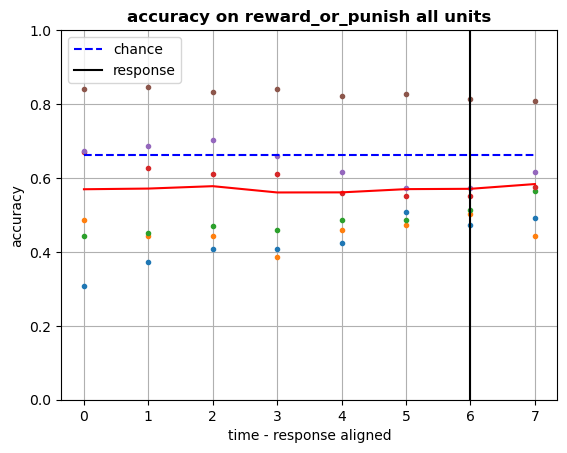

In [34]:
# set threshold for minimum time points before response
thr = 0.6
n_before_resp = 6
n_after_resp = 2
n_timepoints = n_before_resp+ n_after_resp

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

# for each airpuff session:
for session in range(14,20):

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
        
    # normalize calcium data, bringing the firing of single units on the same scale. 
    z_units = scipy.stats.zscore(channels_array)
    # split traces data by trials
    X_norm = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X_norm[i] = z_units[lower_bound:upper_bound,:]
        
    #### DECODING ####
    selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1
    n_trials = np.sum(selected_trials)

    X_response = np.zeros(shape=(n_trials, n_timepoints , n_channels ))
    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            x = X_norm[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
            X_response[j,:,:] = x
            j +=1

    # transpose to have X in shape [n_trials, n_channels, n_timepoints]
    X_response = X_response.transpose(0,2,1)
    
    # analysis on reward and punishment, aligned at response
    decode_str = 'reward_or_punish'
    b = trials_is_reward[0:-1]
    y = b[selected_trials==1]

    # ANALYSIS ALL 
    print("all units decoding - response aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)

    # use only last kernel
    n_splits=3
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):
        # if we want to decode from a group of units only
        # units_selection = np.arange(25,34)
        # xt = X_response[:,units_selection,t]

        # if we want to decode from all the units
        xt = X_response[:,:,t]


        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1
    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))
            
# plot reward or punishment at response (across sessions)
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.') #,color='r')

plt.plot(x, y1,'r')
plt.plot(x, y2, '--b', label="chance")

# shade: standard deviation of average accuracy & chance level
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=n_before_resp, color='k', label="response")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

In [35]:
# saving as pickle file
output_filename = "assemblies_activity/before_response_airpuff_activity.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(y1, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis licking left or right across all sessions (BEFORE response)

all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.9152542372881356
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.05714285714285714
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.4424778761061947
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.7033898305084746
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.5714285714285714
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.5448717948717948


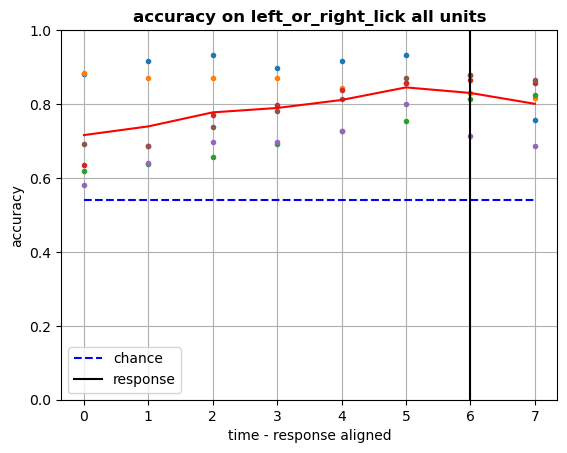

In [36]:
# set threshold for minimum time points before response
thr = 0.6
n_before_resp = 6
n_after_resp = 2
n_timepoints = n_before_resp+ n_after_resp

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

# for each airpuff session:
for session in range(14,20):

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
        
    # normalize calcium data, bringing the firing of single units on the same scale. 
    z_units = scipy.stats.zscore(channels_array)
    # split traces data by trials
    X_norm = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X_norm[i] = z_units[lower_bound:upper_bound,:]
        
    #### DECODING ####
    selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1
    n_trials = np.sum(selected_trials)

    X_response = np.zeros(shape=(n_trials, n_timepoints , n_channels ))
    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            x = X_norm[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
            X_response[j,:,:] = x
            j +=1

    # transpose to have X in shape [n_trials, n_channels, n_timepoints]
    X_response = X_response.transpose(0,2,1)
    
    # analysis lick left or right, aligned at response
    decode_str = 'left_or_right_lick'
    b = trials_is_right_lick[0:-1]
    y = b[selected_trials==1]

    # ANALYSIS ALL 
    print("all units decoding - response aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)

    # use only last kernel
    n_splits=3
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):
        # if we want to decode from a group of units only
        # units_selection = np.arange(25,34)
        # xt = X_response[:,units_selection,t]

        # if we want to decode from all the units
        xt = X_response[:,:,t]


        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1
    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))
            
# plot reward or punishment at response (across sessions)
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.') #,color='r')

plt.plot(x, y1,'r')
plt.plot(x, y2, '--b', label="chance")

# shade: standard deviation of accuracy & chance level
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=n_before_resp, color='k', label="response")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

In [37]:
# saving as pickle file
output_filename = "assemblies_activity/lick_airpuff_activity.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(y1, fp, protocol=pickle.HIGHEST_PROTOCOL)